<a href="https://colab.research.google.com/github/DoubleCyclone/CNN-From-Scratch/blob/main/notebooks/CNN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will build a **Convolutional Neural Network Model** with **NumPy** and train it on the [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/). Hoping to achieve a test accuracy of 70%.

# 1 - Setup and Data Acquisition
I will start this menacing task by importing the packages required as usual.

In [17]:
from torchvision import datasets
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

After the package imports, the first thing I have to do is load the dataset. I will also split the training data into Training and Validation sets so that while training the model we can use the Validation set for a more accurate metrics summary of the model. I know that the dataset has 50000 training and 10000 test samples so I will divide it to 40000 training, 10000 validation and 10000 test samples instead.

In [18]:
# Load the train and test datasets
dataset_full = datasets.CIFAR10(root="data", train=True, download=True)
dataset_test = datasets.CIFAR10(root="data", train=False, download=True)

# Split the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataset_full.data, dataset_full.targets, test_size=0.2, stratify=dataset_full.targets, random_state=42)
X_test = dataset_test.data
y_test = dataset_test.targets

print(f"Training data : {X_train.shape}, labels : {len(y_train)}")
print(f"Validation data : {X_val.shape}, labels : {len(y_val)}")
print(f"Test data : {X_test.shape}, labels : {len(y_test)}")
print(f"Classes : {dataset_full.classes}, count {len(dataset_full.classes)}")

Training data : (40000, 32, 32, 3), labels : 40000
Validation data : (10000, 32, 32, 3), labels : 10000
Test data : (10000, 32, 32, 3), labels : 10000
Classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], count 10


One sample's shape is 32x32x3 which represents the size of the image and the channels in that image. Channel count being 3 here means that the image is composed of Red, Green and Blue values on top of each other (RGB). If it was comprised of a single channel, that would have meant that the image was monochromatic. (Like in the [MNIST Digit Classification dataset](https://www.kaggle.com/code/hojjatk/read-mnist-dataset)). Also, there are 10 classes in the dataset comprised of some animal species and vehicles.

Let's visualize a few images to get an idea about how they look.

In [19]:
def visualize_random(X, size, amount) :
  # Pick random indexes
  rng = np.random.default_rng()
  random_idx = rng.choice(len(X), size=amount, replace=False)

  plt.figure(figsize=(amount * 3, 2.5)) # Adjust figure size for better visualization
  for j, i in enumerate(random_idx) :
    # Resize image using LANCZOS filter for high-quality upscaling
    img = Image.fromarray(X[i]).resize((size, size), resample=Image.Resampling.LANCZOS)
    plt.subplot(1, amount, j + 1)
    plt.imshow(img)
    plt.title(f"Index: {i}, Label : {dataset_full.classes[y_train[i]]}") # Set the index and class as the title
    plt.axis('off') # Hide axes for cleaner image display
  plt.tight_layout() # Adjust subplot parameters for a tight layout
  plt.show() # Display the plot

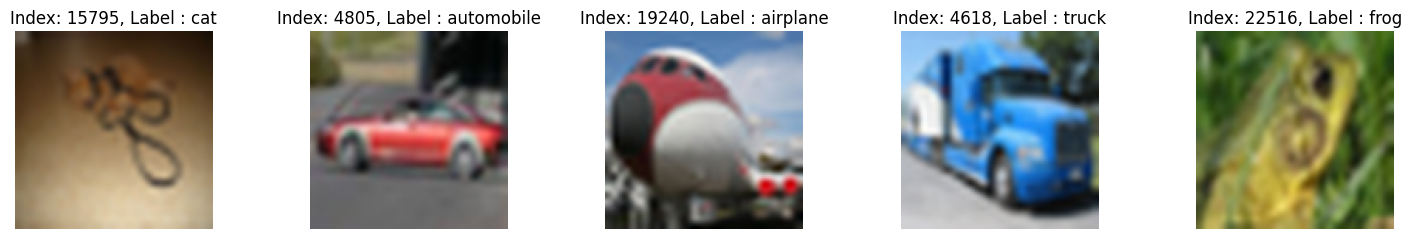

In [20]:
visualize_random(X_train, 128, 5)

As the images are really small originally, upscaling them leads to low res visualizations but they are still understandable.

We use CNNs instead of NNs for image classifications because they keep information about the pixels' neighbors as well as the pixels themselves, learning about patterns by themselves.

For my simple model, I will have the architecture built like ```Conv(32 filters) -> MaxPooling -> Conv(64 filters) -> MaxPooling -> Dense(128) -> Dense(10)``` and I will use filters of size 3x3 with no stride or padding.

# 2 - Building CNN Mathematical Components
At first, I need to convert the images from 3 dimensional arrays to 2 dimensional arrays by getting rid of the channel dimension and just concatenating the channels together in such a way that every column represents all the information gathered from one position from the sliding window technique (1 column = kernel size x channel size amount of data). This approach is called **im2col**.

In [167]:
def im2col(sample, kernel) :
  kernel_h, kernel_w = kernel.shape  # Get kernel dimensions
  permuted = np.transpose(sample, (2, 0, 1)) # From HxWxC to CxHxW
  C, H, W = permuted.shape # Get all dimensions for the image
  output_h = H - kernel_h + 1
  output_w = W - kernel_w + 1
  col_amount = output_h * output_w # get required column amount
  row_amount = kernel.size * len(permuted) # get required row amount
  output = np.empty((col_amount, row_amount)) # Create a new array with the calculated dimensions, will be transposed later
  counter = 0 # counter stored to fill all rows
  for i in range(output_h) : # image H - (kernel H + 1)
    for j in range(output_w) : # image W - (kernel W + 1)
      output[counter] = permuted[:, i:i+kernel_h, j:j+kernel_w].flatten() # add all channels' data encapsulated by kernel and flatten it into a row
      counter += 1
  output = output.T # transpose to correct shape
  print(output.shape)
  return output

In [173]:
test_kernel = np.ones(shape=(3,3))
im2col(X_train[0], test_kernel)

(27, 900)


array([[ 56.,  59.,  70., ..., 157., 146., 135.],
       [ 59.,  70.,  96., ..., 146., 135., 113.],
       [ 70.,  96.,  78., ..., 135., 113., 128.],
       ...,
       [ 47.,  67.,  69., ...,  97., 110.,  91.],
       [ 67.,  69.,  75., ..., 110.,  91.,  77.],
       [ 69.,  75.,  72., ...,  91.,  77.,  62.]])